In [1]:
pwd

'/Users/james/JWSTdata/GJ341b/MAST_2023-03-12T0537/JWST/reduction01/reduction_notebooks'

Now we can make the spectroscopic light curves given all spectra are aligned

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import reduction_utils.wavelength_binning as wb
import reduction_utils.wavelength_calibration as wc
import matplotlib.pyplot as plt
import pickle
import os
import reduction_utils.cosmic_removal as c
from astropy.io import fits

In [4]:
import imp
imp.reload(wb)
imp.reload(c)

/var/folders/xl/rnnh5p8s2077d5172fw8_lzm0000gn/T/ipykernel_30512/1704826064.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<module 'reduction_utils.cosmic_removal' from '/Users/james/python/reduction_utils/cosmic_removal.py'>

In [5]:
# resampled arrays
f = pickle.load(open('../pickled_objects/star1_flux_resampled.pickle','rb'))
e = pickle.load(open('../pickled_objects/star1_error_resampled.pickle','rb'))

sky = pickle.load(open('../pickled_objects/sky1_resampled.pickle','rb'))
xpos = pickle.load(open('../pickled_objects/xpos1_resampled.pickle','rb'))
ypos = pickle.load(open('../pickled_objects/ypos1.pickle','rb'))

fwhm = pickle.load(open("../pickled_objects/fwhm_1.pickle","rb"))

nframes,npixels = f.shape

time = pickle.load(open("../pickled_objects/time.pickle","rb"))

In [6]:
int(time[0])

60013

<IPython.core.display.Javascript object>


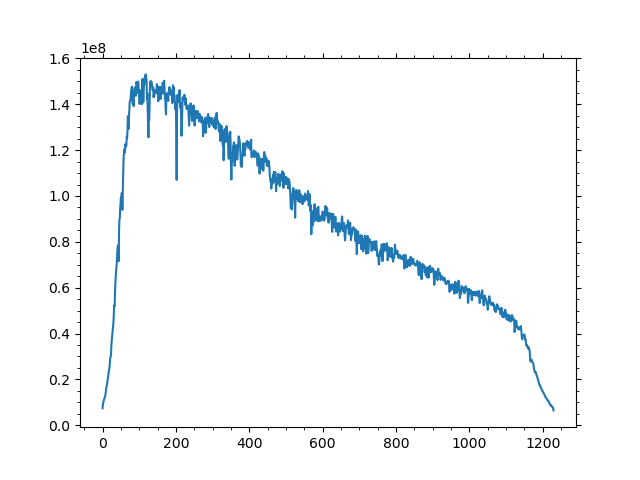

In [7]:
plt.figure()
plt.plot(np.nansum(f,axis=0))
plt.show()

In [9]:
f.shape,e.shape,sky.shape,xpos.shape,ypos.shape,fwhm.shape,time.shape

((4652, 1230),
 (4652, 1230),
 (4652, 1230),
 (4652, 1230),
 (4652,),
 (4652,),
 (4652,))

In [10]:
wvl_solution = pickle.load(open("../pickled_objects/wvl_solution.pickle","rb"))

<IPython.core.display.Javascript object>


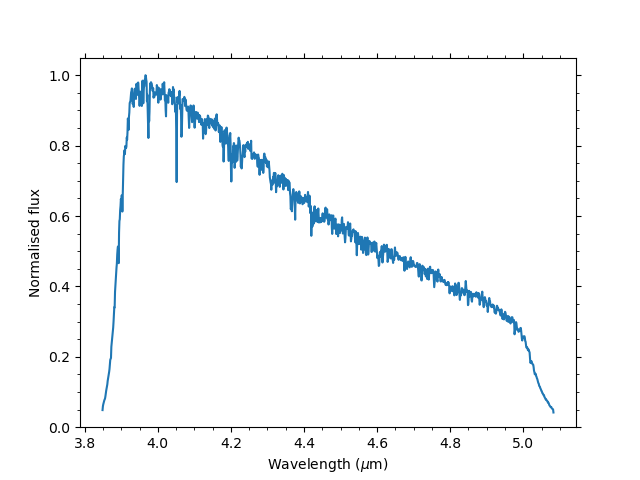

In [11]:
plt.figure()
plt.plot(wvl_solution,f[0]/np.nanmax(f[0]))
plt.ylim(0.,1.05)
plt.ylabel("Normalised flux")
plt.xlabel("Wavelength ($\mu$m)")
# plt.savefig("stellar_spectrum.png",bbox_inches="tight")
plt.show()

<IPython.core.display.Javascript object>


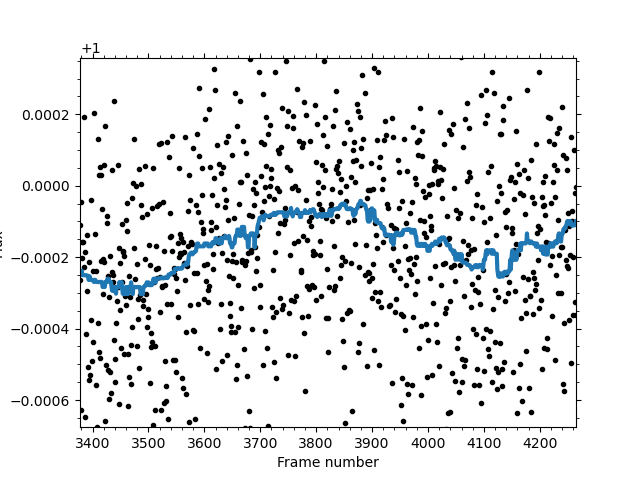

In [12]:
plt.figure()
plt.plot(f.mean(axis=1)/f.mean(),'k.')
plt.plot(np.arange(100,len(f)-100),wb.signal.medfilt(f.mean(axis=1)/f.mean(),101)[100:-100],lw=3)
plt.ylabel('Flux')
plt.xlabel('Frame number')
plt.show()

In [15]:
contact1 = 1400
contact4 = 3673

Compare my calculated flux errors with the photon uncertainty to make sure these are comparable

<IPython.core.display.Javascript object>


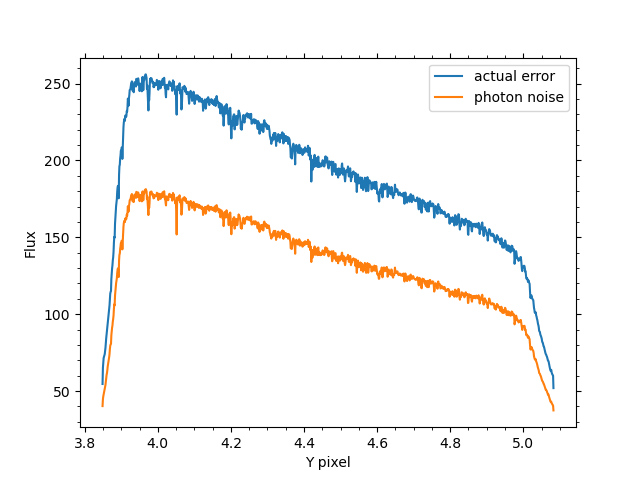

In [16]:
plt.figure()
plt.plot(wvl_solution,e[nframes//2],label="actual error")
plt.plot(wvl_solution,np.sqrt(f[nframes//2]),label="photon noise")
plt.ylabel("Flux")
plt.xlabel("Y pixel")
plt.legend()
plt.show()

# White light curve

In [17]:
imp.reload(wb)

wl_f = np.nansum(f,axis=1)
wl_e = np.sqrt(np.nansum(e**2,axis=1))

wl_sky = sky.sum(axis=1)
wl_sky = (wl_sky - wl_sky.mean())/wl_sky.std()

wl_xpos = xpos.sum(axis=1)
wl_xpos = (wl_xpos - wl_xpos.mean())/wl_xpos.std()

# normalise
wl_f_norm,wl_e_norm = wb.normalise_flux(wl_f,wl_e,contact1,contact4)

time_norm = time - int(time[0])

In [18]:
from scipy.ndimage import gaussian_filter

<IPython.core.display.Javascript object>


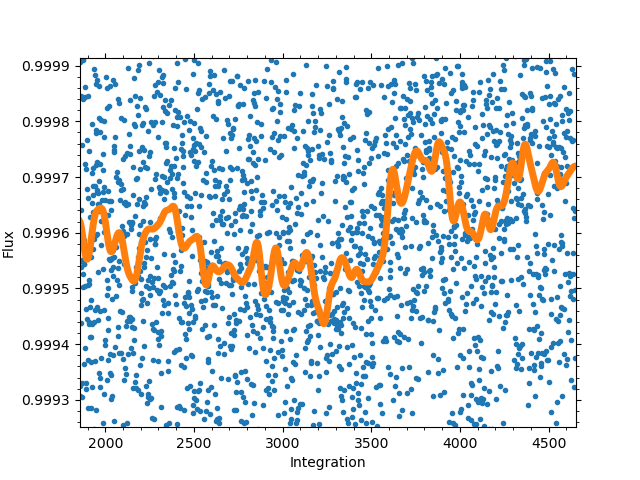

<IPython.core.display.Javascript object>


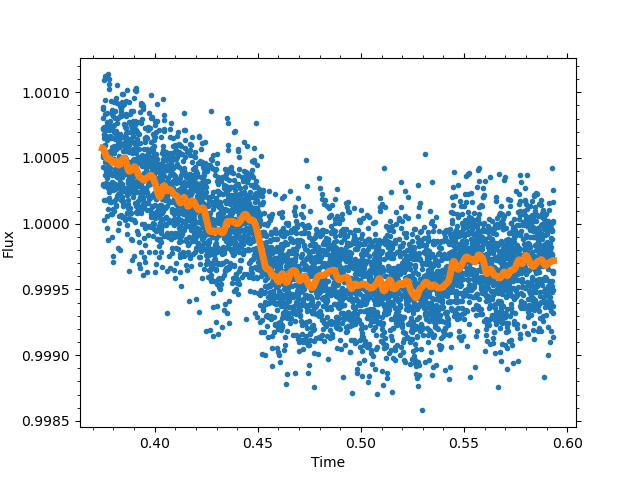

In [19]:
# unweighted mean light curve
plt.figure()
plt.plot(wl_f_norm[0],marker='.',ls="None")
plt.plot(gaussian_filter(wl_f_norm[0], 20),lw=5)
plt.xlabel("Integration")
plt.ylabel("Flux")
plt.savefig("gj341b_transit1_white_light_curve.png",bbox_inches="tight",dpi=360)
plt.show()

plt.figure()
plt.plot(time_norm,wl_f_norm[0],marker='.',ls="None")
plt.plot(time_norm,gaussian_filter(wl_f_norm[0], 20),lw=5)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

In [20]:
contact2 = 1678
contact3 = 3477

In [21]:
tf = time[contact3] - time[contact2]
tt = time[contact4] - time[contact1]

print(tf,24*tf)
print(tt,24*tt)

0.0845592289842898 2.0294214956229553
0.10683887032064376 2.5641328876954503


Plot ancillary data

<IPython.core.display.Javascript object>


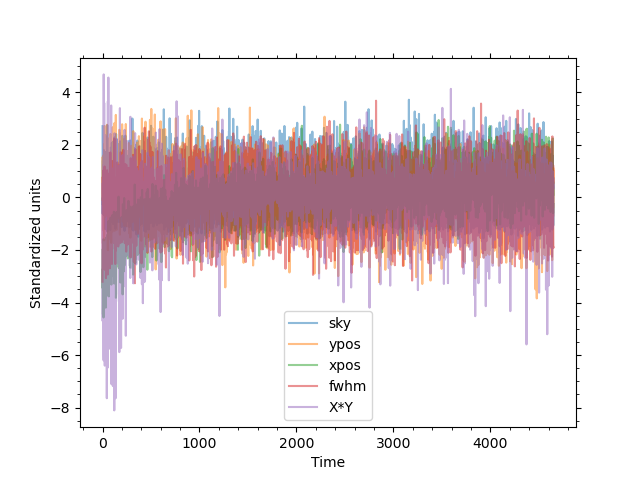

In [22]:
ypos_norm = (ypos-ypos.mean())/ypos.std()
fwhm_norm = (fwhm-fwhm.mean())/fwhm.std()
time_norm = time - int(time[0])
xy = wl_xpos*ypos_norm
xy_norm = (xy-xy.mean())/xy.std()
# bias_scale_factor = (bias_scale_factor - bias_scale_factor.mean())/bias_scale_factor.std()

plt.figure()
plt.plot(wl_sky,label="sky",alpha=0.5)
plt.plot(ypos_norm,label="ypos",alpha=0.5)
plt.plot(wl_xpos,label="xpos",alpha=0.5)
plt.plot(fwhm_norm,label="fwhm",alpha=0.5)
plt.plot(xy_norm,label="X*Y",alpha=0.5)
# plt.plot(bias_scale_factor,label="Bias scale factor",alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Standardized units")
plt.show()

In [23]:
try:
    os.mkdir("../pickled_objects/WL/")
except:
    pass

pickle.dump(wl_f_norm[0],open('../pickled_objects/WL/WL_flux.pickle','wb'))
pickle.dump(wl_e_norm[0],open('../pickled_objects/WL/WL_error.pickle','wb'))
pickle.dump(wl_xpos,open('../pickled_objects/WL/WL_xpos.pickle','wb'))
pickle.dump(wl_sky,open('../pickled_objects/WL/WL_sky.pickle','wb'))

wl_wavelength_centre = wvl_solution.mean()
wl_wavelength_span = wvl_solution[-1]-wvl_solution[0]
wl_wavelength_edges = [wvl_solution[0],wvl_solution[-1]]

new_tab = open("../pickled_objects/WL/WL_wavelengths.dat","w")
new_tab.write("White light wavelength centre = %f um \n"%wl_wavelength_centre)
new_tab.write("White light wavelength span = %f um \n"%wl_wavelength_span)
new_tab.write("White light wavelength edges = %f, %f um \n"%(wl_wavelength_edges[0],wl_wavelength_edges[1]))
new_tab.close()

In [24]:
print("WL wvl centre = %f um; WL wvl span = %f um"%(wl_wavelength_centre,wl_wavelength_span))

WL wvl centre = 4.465665 um; WL wvl span = 1.233934 um


Save common arrays

In [25]:
pickle.dump(time_norm,open("../pickled_objects/time_norm.pickle","wb"))
pickle.dump(fwhm_norm,open("../pickled_objects/fwhm_norm.pickle","wb"))
pickle.dump(ypos_norm,open("../pickled_objects/ypos_norm.pickle","wb"))
# pickle.dump(bias_scale_factor,open("../pickled_objects/bias_scale_factor_norm.pickle","wb"))

# wavelength bins

In [26]:
help(wb.create_wvl_bins)

Help on function create_wvl_bins in module reduction_utils.wavelength_binning:

create_wvl_bins(wvl_solution, bin_width=None, first_pixel=0, last_pixel=None, native_resolution=False)
    A function that defines the bin edges and centres given bin width (in pixels) + first and last pixels.
    
    Inputs:
    wvl_solution - the wavelength solution in A/um
    bin_width - the width of the bins in pixels. Not necessary if native_resolution = Tue
    first_pixel - the first pixel to start the bins at. Default = first pixel
    last_pixel - the final pixel to end the bins at. Default = final pixel
    native_resolution - True/False - are we working at the native resolution of the instrument?
                    If so, the bin centres = wvl solution and bin_width = 1
    
    Returns:
    bin_edges,bin_centres,bin_widths,nbins - the edges, centres, widths (all in wavelength units) and number of bins with this setup



In [27]:
bin_width = 20 # pixels
if bin_width == 1:
    pixel_resolution = True
else:
    pixel_resolution = False

wb_bin_edges,wb_bin_centres,wb_bin_widths,wb_nbins = wb.create_wvl_bins(wvl_solution,bin_width=bin_width,\
                                                                        native_resolution=pixel_resolution)

62 bins created with this setup, with a resolution R between 192--561 and a mean R = 227


In [28]:
help(wb.simple_bin)

Help on function simple_bin in module reduction_utils.wavelength_binning:

simple_bin(flux, flux_error, ancillary_data, wvl_solution, bin_edges, weighted=True, native_resolution=False, standardise_input=True)
    A function that takes advantage of numpy to speed up the binning of large data sets.
    Much preferable to wvl_bin_data() when analysing a single star.
    
    Inputs:
    flux - the stellar spectra for each frame
    flux_error the uncertainties in the stellar spectra for each frame
    ancillary_data - a dictionary of ancillary data to be binned (e.g., background, x position)
    wvl_solution - the wavelength solution / wavelength array
    bin_edges - the edges of the bins in a 1D array/list
    weighted - True/False - do you want to perform a weighted mean? Default = True
    native_resolution - True/False - are we making light curves at the native resolution? If so, bin_edges and weighted is ignored
    standardise_input - True/False - do you want to standardise the anc

In [29]:
imp.reload(wb)

ancillary = {"sky":sky,"xpos":xpos}

bf_wb,be_wb,ba_wb = wb.simple_bin(f,e,ancillary,wvl_solution,\
                                  wb_bin_edges,weighted=False,native_resolution=pixel_resolution)

# normalised
bf_wb_norm,be_wb_norm = wb.normalise_flux(bf_wb,be_wb,contact1,contact4)

Working on bin 1/62
N points in bin = (4652, 20)
Working on bin 2/62
N points in bin = (4652, 20)
Working on bin 3/62
N points in bin = (4652, 20)
Working on bin 4/62
N points in bin = (4652, 20)
Working on bin 5/62
N points in bin = (4652, 20)
Working on bin 6/62
N points in bin = (4652, 20)
Working on bin 7/62
N points in bin = (4652, 20)
Working on bin 8/62
N points in bin = (4652, 20)
Working on bin 9/62
N points in bin = (4652, 20)
Working on bin 10/62
N points in bin = (4652, 20)
Working on bin 11/62
N points in bin = (4652, 20)
Working on bin 12/62
N points in bin = (4652, 20)
Working on bin 13/62
N points in bin = (4652, 20)
Working on bin 14/62
N points in bin = (4652, 20)
Working on bin 15/62
N points in bin = (4652, 20)
Working on bin 16/62
N points in bin = (4652, 20)
Working on bin 17/62
N points in bin = (4652, 20)
Working on bin 18/62
N points in bin = (4652, 20)
Working on bin 19/62
N points in bin = (4652, 20)
Working on bin 20/62
N points in bin = (4652, 20)
Working o

<IPython.core.display.Javascript object>


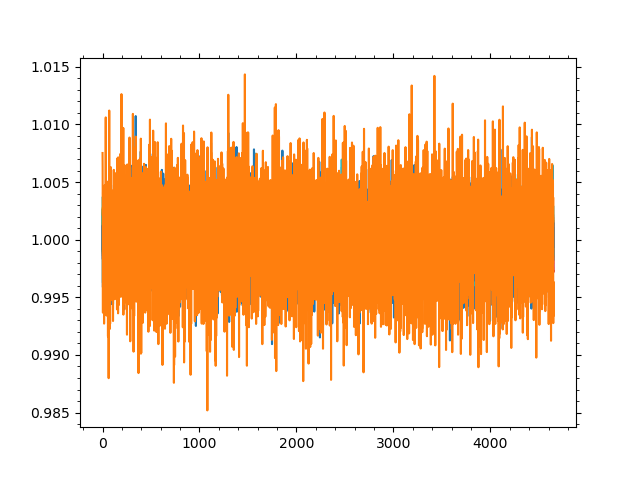

In [30]:
plt.figure()
for i in bf_wb_norm:
    plt.plot(i)
plt.show()

In [31]:
try:
    os.mkdir("../pickled_objects/wb/")
except:
    pass

try:
    os.mkdir("../pickled_objects/wb/%s_pixel_bins"%bin_width)
except:
    pass



pickle.dump(wb_bin_centres,\
            open('../pickled_objects/wb/%s_pixel_bins/wb_bin_centres.pickle'%bin_width,'wb'))

pickle.dump(wb_bin_widths,\
            open('../pickled_objects/wb/%s_pixel_bins/wb_full_widths.pickle'%bin_width,'wb'))

# # with unsmoothed resampling
pickle.dump(bf_wb_norm,\
            open('../pickled_objects/wb/%s_pixel_bins/wb_fluxes.pickle'%bin_width,'wb'))

pickle.dump(be_wb_norm,\
            open('../pickled_objects/wb/%s_pixel_bins/wb_errors.pickle'%bin_width,'wb'))

pickle.dump(ba_wb["xpos"],\
            open('../pickled_objects/wb/%s_pixel_bins/wb_xpos.pickle'%bin_width,'wb'))


pickle.dump(ba_wb["sky"],\
            open('../pickled_objects/wb/%s_pixel_bins/wb_sky.pickle'%bin_width,'wb'))


# Masking the first N frames

In [32]:
# ramp_cut = 300
# print("Clipping at frame %d corresponds to removing the first %d minutes"%(ramp_cut,(time[ramp_cut]-time[0])*24*60))

In [33]:
# try:
#     os.mkdir("../pickled_objects_%d_cut/"%ramp_cut)
# except:
#     pass

# try:
#     os.mkdir("../pickled_objects_%d_cut/WL/"%ramp_cut)
# except:
#     pass

# pickle.dump(wl_f_norm[0][ramp_cut:],open('../pickled_objects_%d_cut/WL/WL_flux.pickle'%ramp_cut,'wb'))
# pickle.dump(wl_e_norm[0][ramp_cut:],open('../pickled_objects_%d_cut/WL/WL_error.pickle'%ramp_cut,'wb'))
# pickle.dump(wl_xpos[ramp_cut:],open('../pickled_objects_%d_cut/WL/WL_xpos.pickle'%ramp_cut,'wb'))
# pickle.dump(wl_sky[ramp_cut:],open('../pickled_objects_%d_cut/WL/WL_sky.pickle'%ramp_cut,'wb'))

# wl_wavelength_centre = wvl_solution.mean()
# wl_wavelength_span = wvl_solution[-1]-wvl_solution[0]
# wl_wavelength_edges = [wvl_solution[0],wvl_solution[-1]]

# new_tab = open("../pickled_objects_%d_cut/WL/WL_wavelengths.dat"%ramp_cut,"w")
# new_tab.write("White light wavelength centre = %f um \n"%wl_wavelength_centre)
# new_tab.write("White light wavelength span = %f um \n"%wl_wavelength_span)
# new_tab.write("White light wavelength edges = %f, %f um \n"%(wl_wavelength_edges[0],wl_wavelength_edges[1]))
# new_tab.close()

# pickle.dump(time_norm[ramp_cut:],open("../pickled_objects_%d_cut/time_norm.pickle"%ramp_cut,"wb"))
# pickle.dump(fwhm_norm[ramp_cut:],open("../pickled_objects_%d_cut/fwhm_norm.pickle"%ramp_cut,"wb"))
# pickle.dump(ypos_norm[ramp_cut:],open("../pickled_objects_%d_cut/ypos_norm.pickle"%ramp_cut,"wb"))
# pickle.dump(xy_norm[ramp_cut:],open("../pickled_objects_%d_cut/xy_norm.pickle"%ramp_cut,"wb"))

# try:
#     os.mkdir("../pickled_objects_%d_cut/wb/"%ramp_cut)
# except:
#     pass

# try:
#     os.mkdir("../pickled_objects_%d_cut/wb/%s_pixel_bins"%(ramp_cut,bin_width))
# except:
#     pass

# pickle.dump(wb_bin_centres,\
#             open('../pickled_objects_%d_cut/wb/%s_pixel_bins/wb_bin_centres.pickle'%(ramp_cut,bin_width),'wb'))

# pickle.dump(wb_bin_widths,\
#             open('../pickled_objects_%d_cut/wb/%s_pixel_bins/wb_full_widths.pickle'%(ramp_cut,bin_width),'wb'))

# pickle.dump(bf_wb_norm[:,ramp_cut:],\
#             open('../pickled_objects_%d_cut/wb/%s_pixel_bins/wb_fluxes.pickle'%(ramp_cut,bin_width),'wb'))

# pickle.dump(be_wb_norm[:,ramp_cut:],\
#             open('../pickled_objects_%d_cut/wb/%s_pixel_bins/wb_errors.pickle'%(ramp_cut,bin_width),'wb'))

# pickle.dump(ba_wb["xpos"][:,ramp_cut:],\
#             open('../pickled_objects_%d_cut/wb/%s_pixel_bins/wb_xpos.pickle'%(ramp_cut,bin_width),'wb'))


# pickle.dump(ba_wb["sky"][:,ramp_cut:],\
#             open('../pickled_objects_%d_cut/wb/%s_pixel_bins/wb_sky.pickle'%(ramp_cut,bin_width),'wb'))


In [34]:
# pickle.dump(f[ramp_cut:],open("../pickled_objects_%d_cut/star1_flux_resampled.pickle"%ramp_cut,"wb"))
# pickle.dump(e[ramp_cut:],open("../pickled_objects_%d_cut/star1_error_resampled.pickle"%ramp_cut,"wb"))
# pickle.dump(time[ramp_cut:],open("../pickled_objects_%d_cut/BJD_TDB_time.pickle"%ramp_cut,"wb"))
# pickle.dump(wvl_solution,open("../pickled_objects_%d_cut/wvl_solution_miri.pickle"%ramp_cut,"wb"))